In [237]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import string
import warnings
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import BertTokenizer, BertModel, TransfoXLTokenizer, TransfoXLModel
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, max_error
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss
import pytorch_lightning as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint
from lightning.pytorch import Trainer, seed_everything
from pytorch_forecasting.metrics import MAPE, QuantileLoss
import torch

warnings.filterwarnings('ignore')

In [238]:
# Seed everything for reproducibility
seed_everything(42)

Seed set to 42


42

In [239]:
data = pd.read_csv('ghg-emissions2.csv')
data = data[:-2]
print(data.head(10))

   iso Country/Region    unit  1850  1851  1852  1853  1854  1855  1856  ...  \
0  BGD     Bangladesh  MtCO2e  21.5  21.7  22.0  22.2  22.4  22.6  22.8  ...   

    2010   2011   2012   2013   2014   2015   2016   2017   2018   2019  
0  139.0  144.0  150.0  152.0  158.0  168.0  171.0  179.0  188.0  201.0  

[1 rows x 173 columns]


In [240]:
data = data.melt(id_vars=['iso', 'Country/Region', 'unit'], var_name='Year', value_name='Emissions')
data = data[(data['Country/Region'] == 'Bangladesh') & (data['unit'] == 'MtCO2e')]
data['Year'] = data['Year'].astype(int)
data = data[['Country/Region','Year', 'Emissions']]

In [241]:
data.tail(10)

,Country/Region,Year,Emissions
160,Bangladesh,2010,139.0
161,Bangladesh,2011,144.0
162,Bangladesh,2012,150.0
163,Bangladesh,2013,152.0
164,Bangladesh,2014,158.0
165,Bangladesh,2015,168.0
166,Bangladesh,2016,171.0
167,Bangladesh,2017,179.0
168,Bangladesh,2018,188.0
169,Bangladesh,2019,201.0


In [242]:
# Normalize the emissions
scaler = StandardScaler()
data['Emissions'] = scaler.fit_transform(data[['Emissions']])

In [243]:
# Split the data into training and test sets
train_data = data[data['Year'] <= 1989]
test_data = data[data['Year'] > 1989]

In [244]:
# Prepare the dataset for PyTorch Forecasting
max_prediction_length = 25
max_encoder_length = 5

In [223]:
# len(train_data)
# max_prediction_length
max_encoder_length

5

In [245]:
training = TimeSeriesDataSet(
    train_data,
    time_idx='Year',
    target='Emissions',
    group_ids=['Country/Region'],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_unknown_reals=['Emissions'],
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

In [246]:

validation = TimeSeriesDataSet.from_dataset(training, test_data, predict=True, stop_randomization=True)

In [247]:
# Create the dataloaders
batch_size = 64
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)


In [248]:
quantiles = [0.1, 0.5, 0.9]
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001,
    hidden_size=32,
    attention_head_size=4,
    dropout=0.2,
    hidden_continuous_size=16,
    output_size=len(quantiles),  # Adjusted for quantiles
    loss=QuantileLoss(quantiles=quantiles),
    log_interval=10,
    reduce_on_plateau_patience=4,
)

In [249]:
# Set up the model
pl_trainer = Trainer(
    max_epochs=100, 
    accelerator="cpu",
    gradient_clip_val=0.1,
    # limit_train_batches=30,  # comment this in real implementation
    callbacks=[EarlyStopping(monitor="val_loss", patience=10, min_delta=1e-4)],
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 160    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 5.7 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 3.8 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.8 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K  

Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  5.93it/s, v_num=29, train_loss_step=0.0873, val_loss=2.460, train_loss_epoch=0.0839]

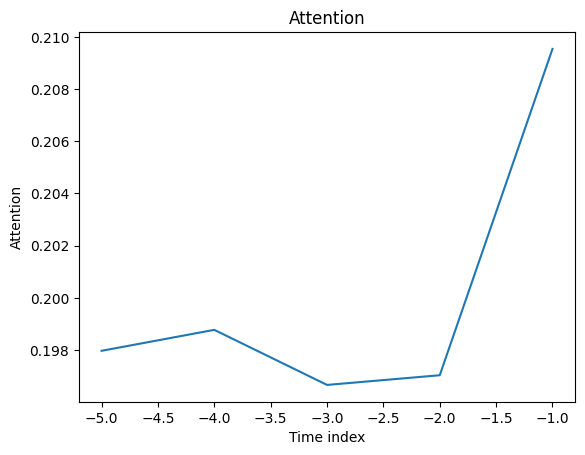

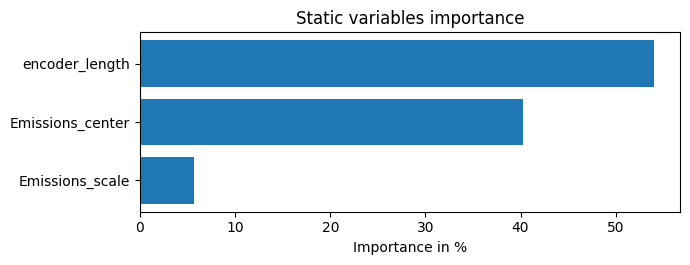

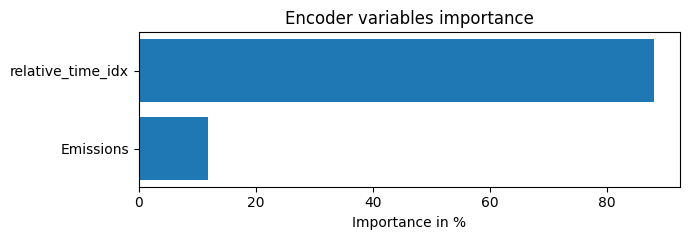

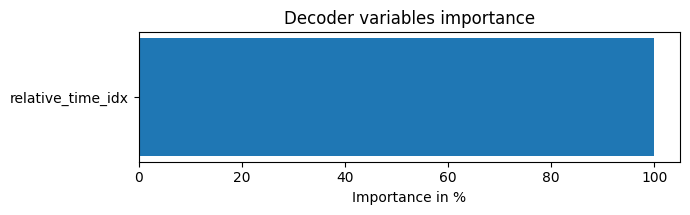

In [250]:
# Train the model
pl_trainer.fit(tft, train_dataloader, val_dataloader)

In [176]:
# Predict emissions from 1990 to 2019
best_model_path = pl_trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
predictions = best_tft.predict(val_dataloader)

In [179]:
# Ensure predictions are aligned with the test data
predicted_values = predictions.detach().cpu().numpy().flatten()
true_values = test_data['Emissions'].values[:len(predicted_values)]

In [180]:
# Calculate performance metrics
mae = mean_absolute_error(true_values, predicted_values)
mse = mean_squared_error(true_values, predicted_values)
rmse = np.sqrt(mse)
r2 = r2_score(true_values, predicted_values)
max_err = max_error(true_values, predicted_values)
accuracy = 1 - np.mean(np.abs((true_values - predicted_values) / true_values))  # Calculate accuracy

# Print performance metrics
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')
print(f'Max Error: {max_err}')
print(f'Accuracy: {accuracy}')

MAE: 65.42063345336913
MSE: 5299.454341776519
RMSE: 72.79735120027733
R2 Score: -3.964664830024187
Max Error: 122.4554328918457
Accuracy: 0.3835111231681251


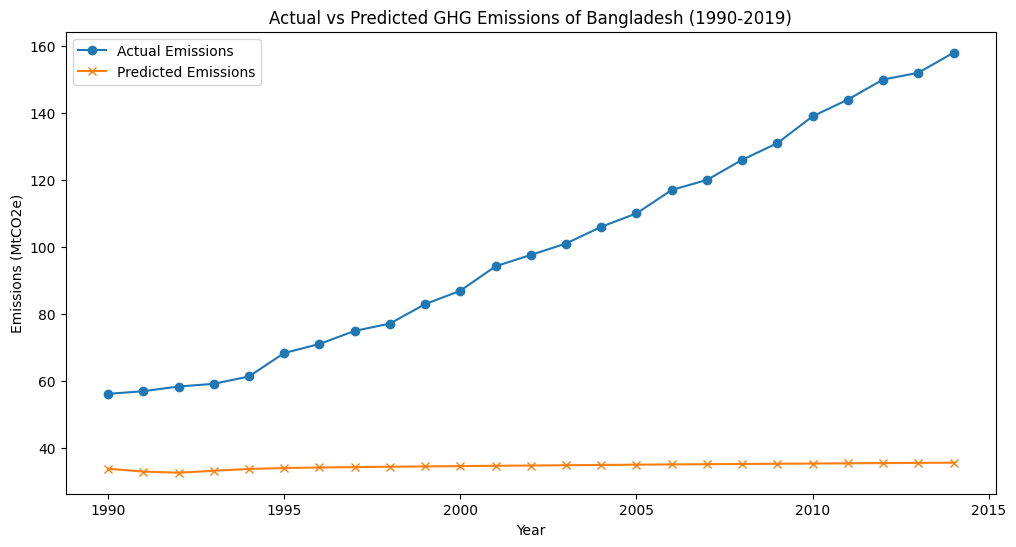

In [181]:
plt.figure(figsize=(12, 6))
plt.plot(test_data['Year'][:len(predicted_values)], true_values, label='Actual Emissions', marker='o')
plt.plot(test_data['Year'][:len(predicted_values)], predicted_values, label='Predicted Emissions', marker='x')
plt.xlabel('Year')
plt.ylabel('Emissions (MtCO2e)')
plt.title('Actual vs Predicted GHG Emissions of Bangladesh (1990-2019)')
plt.legend()
plt.show()